In [1]:
import numpy as np
import numdifftools as nd
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import sys
sys.path.append("/home/josh/development/sourceFiles/MD-upscaling-utilities/") 

from minimization import *
import time

import scipy as sci

This objective function has a single minimum at [x0, y0]
The behavior of the function can be altered by changing the following parameters
- skew: determines how "valley-like" the function is -- becomes more valley-like when `abs(skew)` is greater or less than unity
- yxSlope: determines the direction that the 'valley' in which the minimum occurs is oriented 
- power: 

In [2]:
def objective_function(args,yxSlope=0.7,skew=12,power=2.2,x0=-33,y0=22.1):

    xf = 1/(1+yxSlope**2)**0.5
    yf = yxSlope*xf
    x = (args[0] - x0)*xf + (args[1] - y0)*yf
    y = (args[0] - x0)*yf - (args[1] - y0)*xf
    return np.abs(np.abs(skew)**(+0.5)*(y))**power \
         + np.abs(np.abs(skew)**(-0.5)*(x))**power + 8
    

Text(0.5, 1.0, '$\\mathrm{log_{10}}[f(x,y)]$')

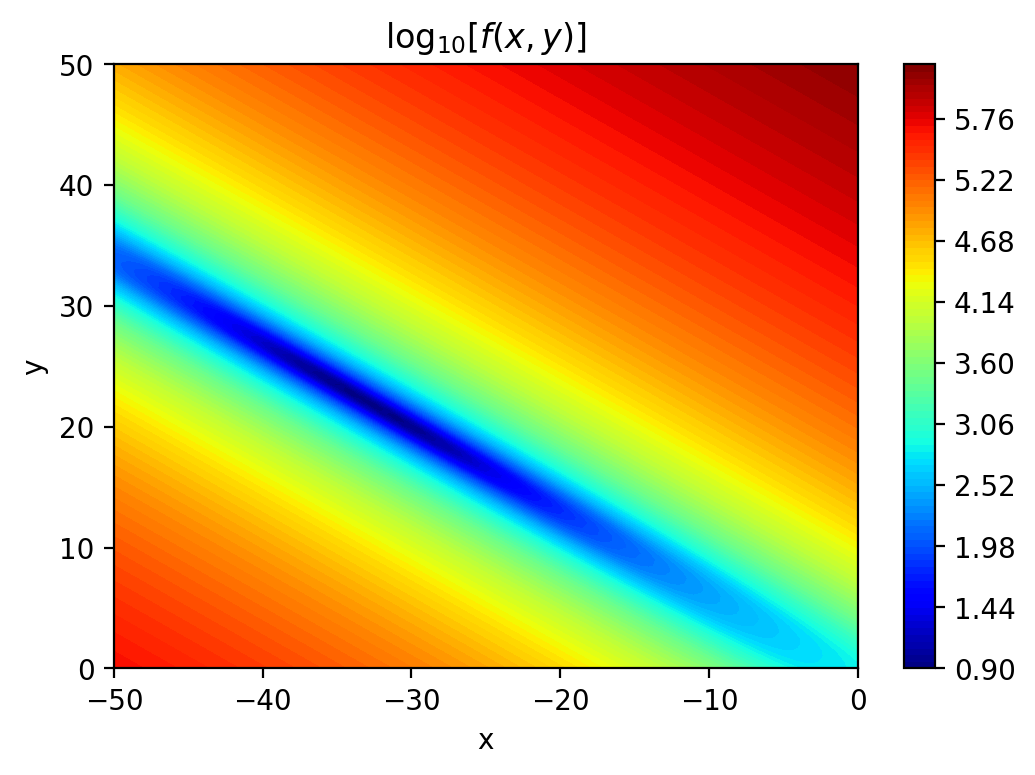

In [3]:
xx = np.linspace(-50,0, 101)
yy = np.linspace(0,50, 101)
xx, yy = np.meshgrid(xx, yy)

kwargs = {'x0':-33, 
          'y0':22.1, 
          'yxSlope':-0.7, 
          'skew': -15,
          'power':2.8}

fig = plt.figure()
fig.set_dpi(200)

fvals = objective_function([xx,yy], **kwargs)
plt.contourf(xx,yy,np.log10(fvals), 100, cmap=plt.cm.jet)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('$\mathrm{log_{10}}[f(x,y)]$')

In [4]:
# define a lambda which wraps the objective function
obj_func = lambda args : (objective_function(args, **kwargs))

# do a minimization with the conjugate gradient + line search method for the 2D function defined above

In [5]:
bounds = Bounds(minVals=[-np.inf, 0], maxVals=[0, np.inf])
otherArgs={
    'stepRange':[1e-1, 100], # step size, min and max 
    'sigma':2, # factor by which the step for the line search is devided
    'bounds':bounds, # bounds for parameters
    'verbose':False, # verbose
    'betaForm': 'WYL' # determines what conjugate gradient formula is used options are 'FR' and 'WYL'
}

guess = np.array([-8,6])

minimizer1 = Minimizer(obj_func,funcParams=[])
result1 = minimizer1.minimize(guess,
                            dxMax=[0.05, 0.05],
                            gradTol=1e-3,
                            dxTol=1e-2, 
                            maxNewtonIter=25, 
                            scheme='cg', 
                            kwargs=otherArgs)

iteration: 1
new guess for variable 1 is less than specified maximum:  -65.23475544648201 < 0.0
Guess exceeds variable bounds. multiplying step size by 0.08422854774180762
which yields a step size of 8.422854774180761
gradient : [116.34972859 118.09385996]
new guess: [-9.47784646  4.5       ]
iteration: 2
setting step to minimum value.
gradient : [ -37.91987628 -101.48350629]
new guess: [-9.47784646  4.55      ]
iteration: 3
new guess for variable 0 is greater than specified maximum:  23.581232595842067 > 0.0
Guess exceeds variable bounds. multiplying step size by 0.2866942071784277
which yields a step size of 28.66942071784277
gradient : [-33.16099216 -94.63791705]
new guess: [-8.88548106  6.24109121]
iteration: 4
setting step to minimum value.
parameter change tolerance achieved ( 0.0 <= 0.01 )
iteration: 5
new guess for variable 1 is less than specified maximum:  -57.13302612819676 < 0.0
Guess exceeds variable bounds. multiplying step size by 0.09848012841913921
which yields a step 

In [6]:
print('result:', result1)
print('number of evaluations:', minimizer1.nEvals)


result: [-18.8779057   14.09373984]
number of evaluations: 64


In [7]:
mpl.rcParams.update({'text.usetex': False})
guessList = np.array([pv[0] for pv in minimizer1.paramVals])
fv= []
a = []
b = []
for i,pv in enumerate(minimizer1.paramVals):
    fv+=minimizer1.funcVals[i]
    a += [pvi[0] for pvi in pv]
    b += [pvi[1] for pvi in pv]
    
#     pvArray = np.array(pv)
#     plt.scatter(pvArray[:,0],pvArray[:,1], c=minimizer.funcVals[i])

fv = np.array(fv)
fv = np.clip(np.log10(fv),-10,4)
pvArray = np.array(pv)
fig = plt.figure()
fig.set_dpi(200)
plt.scatter(a,b, c=fv, marker='s', cmap=plt.cm.jet)
plt.colorbar()
plt.grid()

plt.xlim(-50, 0)
plt.ylim(0, 50)

plt.scatter(guessList[0,0], guessList[0,1], marker='x', s=60, color='k')
plt.plot(guessList[:,0], guessList[:,1], marker='.', markersize=5, color=[0.3 for _ in range(3)])
plt.scatter(guessList[-1,0], guessList[-1,1], marker='+', s=60, color='r')

plt.xlabel('x')
plt.ylabel('y')
plt.title('solution path: conjugate gradient + line search')

Text(0.5, 1.0, 'solution path: conjugate gradient + line search')

# do a minimization with the Newton's method for the same function and initial guess

In [8]:
bounds = Bounds(minVals=[-np.inf, 0], maxVals=[0, np.inf])
otherArgs={
    'bounds':bounds, # bounds for parameters
    'verbose':False, # verbose
}

guess = np.array([-12,20])

minimizer2 = Minimizer(obj_func,funcParams=[])

result2 = minimizer2.minimize(guess,
                            dxMax=[0.05, 0.05],
                            gradTol=1e-3,
                            dxTol=4e-2, 
                            maxNewtonIter=25, 
                            scheme='newton', 
                            kwargs=otherArgs)

iteration: 1
gradient : [4763.02176303 6783.43890401]
new guess: [-24.95352319  22.08427017]
iteration: 2
gradient : [1111.73214119 1584.86643374]
new guess: [-30.96558949  23.18888305]
iteration: 3
gradient : [261.04338558 372.76449594]
new guess: [-35.67949141  25.10579444]
iteration: 4
gradient : [61.30628746 88.82598829]
new guess: [-34.85487523  23.9244645 ]
iteration: 5
gradient : [15.32262392 22.44166196]
new guess: [-34.34894898  23.30226259]
iteration: 6
gradient : [4.15158042 6.19137575]
new guess: [-34.02356071  22.95556067]
iteration: 7
gradient : [1.29777714 1.97700009]
new guess: [-33.82667194  22.76407019]
iteration: 8
gradient : [0.49021718 0.75710761]
new guess: [-33.72665254  22.66813328]
iteration: 9
gradient : [0.21663683 0.33640615]
new guess: [-33.68322703  22.62408047]
iteration: 10
parameter change tolerance achieved ( 0.022570596334194448 <= 0.04 )


In [9]:
print('result:', result2)
print('number of evaluations:', minimizer2.nEvals)

result: [-33.66141803  22.60150987]
number of evaluations: 60


Text(0.5, 1.0, "solution path: Newton's method")

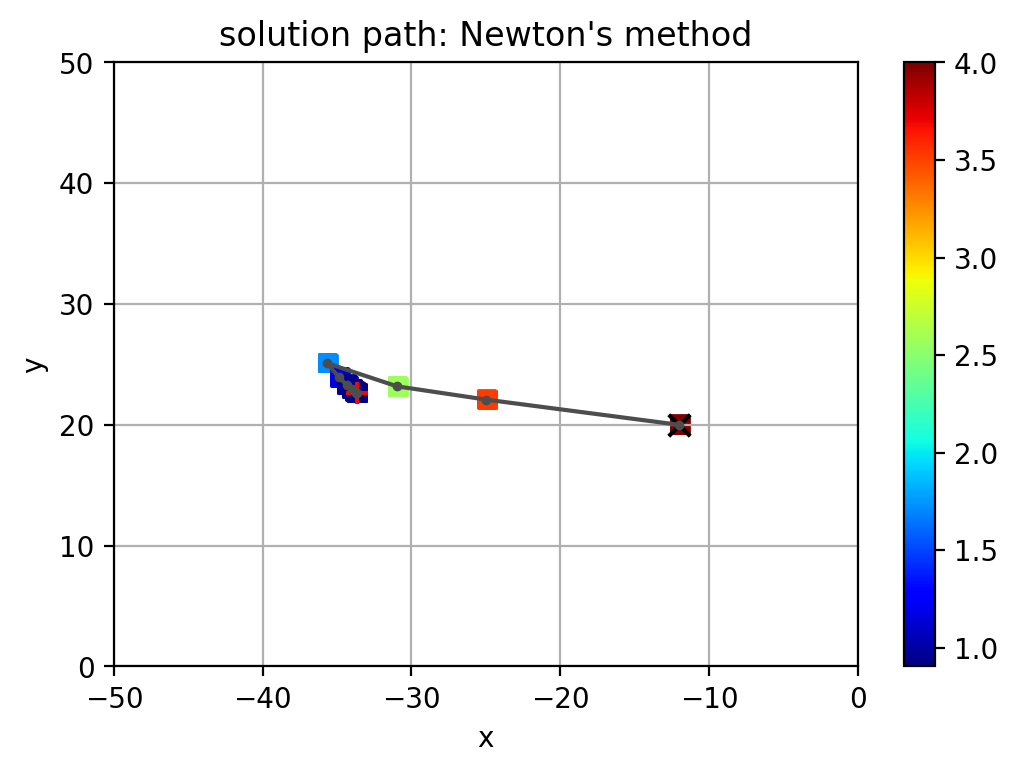

In [10]:
mpl.rcParams.update({'text.usetex': False})
guessList = np.array([pv[0] for pv in minimizer2.paramVals])
fv= []
a = []
b = []
for i,pv in enumerate(minimizer2.paramVals):
    fv+=minimizer2.funcVals[i]
    a += [pvi[0] for pvi in pv]
    b += [pvi[1] for pvi in pv]
    
#     pvArray = np.array(pv)
#     plt.scatter(pvArray[:,0],pvArray[:,1], c=minimizer.funcVals[i])

fv = np.array(fv)
fv = np.clip(np.log10(fv),-10,4)
pvArray = np.array(pv)
fig = plt.figure()
fig.set_dpi(200)
plt.scatter(a,b, c=fv, marker='s', cmap=plt.cm.jet)
plt.colorbar()
plt.grid()

plt.xlim(-50, 0)
plt.ylim(0, 50)

plt.scatter(guessList[0,0], guessList[0,1], marker='x', s=60, color='k')
plt.plot(guessList[:,0], guessList[:,1], marker='.', markersize=5, color=[0.3 for _ in range(3)])
plt.scatter(guessList[-1,0], guessList[-1,1], marker='+', s=60, color='r')
plt.xlabel('x')
plt.ylabel('y')
plt.title("solution path: Newton's method")

# do a minimization of a 4D function using the conjugate gradient + line search method

In [11]:
# this function has a single minimum at args = [0,0,0,0]
func_4D = lambda args: 0.1*np.abs(args[0])**2.5 + \
                   5.0*np.abs(args[1])**2.5 + \
                   1.2*np.abs(args[2])**3   + \
                   6.7*np.abs(args[3])**2.8

bounds = Bounds(minVals=[-np.inf for _ in range(4)], maxVals=[np.inf for _ in range(4)])
otherArgs={
    'stepRange':[1e-1, 100], # step size, min and max 
    'sigma':2.1, # factor by which the step for the line search is devided
    'bounds':bounds, # bounds for parameters
    'verbose':False, # verbose
    'betaForm': 'WYL' # determines what conjugate gradient formula is used options are 'FR' and 'WYL'
}

guess = np.array([-12,20,15,9])

minimizer3 = Minimizer(func_4D,funcParams=[])

result3 = minimizer3.minimize(guess,
                            dxMax=[0.05 for _ in range(4)],
                            gradTol=1e-3,
                            dxTol=4e-2, 
                            maxNewtonIter=25, 
                            scheme='cg', 
                            kwargs=otherArgs)

iteration: 1
gradient : [ -10.35985146 1120.13117567  812.703       984.09859753]
new guess: [-11.8616634    5.0427263    4.14785922  -4.140811  ]
iteration: 2
gradient : [ -10.18085372  142.60378768   62.6866647  -239.47293754]
new guess: [-11.46802431  -1.56097774   0.88688722   3.7457826 ]
iteration: 3
setting step to minimum value.
gradient : [ -9.6772397  -23.79588032   2.99428786 204.55688676]
new guess: [-11.46802431  -1.51097774   0.88688722   3.7457826 ]
iteration: 4
gradient : [ -9.6772397  -22.64351442   2.99428786 204.55688676]
new guess: [-11.22653136  -0.94598999   0.81213403  -1.35871733]
iteration: 5
gradient : [ -9.37252004 -11.04923917   2.5236062  -31.50534832]
new guess: [-10.30150142   0.19993197   0.56114095   0.58123926]
iteration: 6
gradient : [-8.23584681  1.33554088  1.23757036  7.6237625 ]
new guess: [-5.67970667  0.46127031 -0.22071262 -1.51601087]
iteration: 7
setting step to minimum value.
gradient : [ -3.36167862   4.24004168  -0.13864235 -38.5059278 ]
ne

In [26]:
print('result:', result3)
print('number of evaluations:', minimizer3.nEvals)

result: [ 0.01297593  0.01172225 -0.02249439  0.01508299]
number of evaluations: 236


# mimization of the same 4D function with Newton's method

In [29]:
minimizer4 = Minimizer(func_4D,funcParams=[])
otherArgs={
    'bounds':bounds, # bounds for parameters
    'verbose':False, # verbose
}

result4 = minimizer4.minimize(guess,
                            dxMax=[0.05 for _ in range(4)],
                            gradTol=1e-3,
                            dxTol=2e-2, 
                            maxNewtonIter=25, 
                            scheme='newton', 
                            kwargs=otherArgs)

iteration: 1
gradient : [ -10.39225967 1118.03224346  809.994       979.18087485]
new guess: [-3.98331298  6.68332121  7.52497231  4.02218334]
iteration: 2
gradient : [ -1.98741914 215.96951591 203.84475001 229.73757496]
new guess: [-1.31104253  2.24440431  3.78743115  1.80977286]
iteration: 3
gradient : [-0.37514997 42.02504708 51.63468502 54.55036553]
new guess: [-0.42015475  0.7646955   1.918607    0.82637652]
iteration: 4
gradient : [-0.06783257  8.350054   13.2457901  13.28605579]
new guess: [-0.12272743  0.27126675  0.98409184  0.38909915]
iteration: 5
gradient : [-0.01020201  1.75197911  3.48037232  3.40367324]
new guess: [-0.02077427  0.10633106  0.51664299  0.19435357]
iteration: 6
gradient : [-0.00136924  0.41268441  0.95491193  0.9531515 ]
new guess: [0.00149887 0.05054407 0.28258617 0.10715988]
iteration: 7
gradient : [-0.00087494  0.11526856  0.2814778   0.303533  ]
new guess: [0.01202263 0.03105238 0.16504028 0.06760326]
iteration: 8
gradient : [-0.00041561  0.03770265  0

In [30]:
print('result:', result4)
print('number of evaluations:', minimizer4.nEvals)

result: [0.01907544 0.02019829 0.05922626 0.03631885]
number of evaluations: 150
